<a href="https://colab.research.google.com/github/mehrnazeraeisi/Wine/blob/main/Wine_KnnClassification_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [67]:
# [1] تابع جدید برای اولویت‌بندی ویژگی‌ها بر اساس دقت KNN
def features_prioritization_by_accuracy(X, y, features):
    features_scores = []
    knn_cls = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_cls.fit(X_feature, y)
        y_pred = knn_cls.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        features_scores.append((feature, acc))

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
    return df_scores


In [68]:

# [2] تابع امن برای محاسبه دقت روی گروهی از ویژگی‌ها
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)

# [3] بارگذاری دیتاست

In [69]:
data = load_wine()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data= data.target
data_features = data.feature_names

In [70]:
# [4] اولویت‌بندی ویژگی‌ها بر اساس Accuracy
data_scores = features_prioritization_by_accuracy(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (by Accuracy):")
print(data_scores)

🔎 Feature Group Performance Summary (by Accuracy):
                         Feature  Accuracy
6                     flavanoids  0.842697
9                color_intensity  0.780899
11  od280/od315_of_diluted_wines  0.769663
12                       proline  0.764045
0                        alcohol  0.764045
10                           hue  0.747191
5                  total_phenols  0.724719
1                     malic_acid  0.713483
8                proanthocyanins  0.674157
4                      magnesium  0.640449
3              alcalinity_of_ash  0.589888
7           nonflavanoid_phenols  0.584270
2                            ash  0.578652


In [71]:
# [5] دسته‌بندی ویژگی‌ها بر اساس Accuracy
strong_features = data_scores[data_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['Accuracy'] > 0.9)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['Accuracy'] > 0.8)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['Accuracy'] > 0.7) ]['Feature'].tolist()
medium_features_4 = data_scores[(data_scores['Accuracy'] > 0.6) ]['Feature'].tolist()
medium_features_5 = data_scores[(data_scores['Accuracy'] > 0.5) ]['Feature'].tolist()
poor_features = data_scores[data_scores['Accuracy'] <= 0.5]['Feature'].tolist()

In [72]:
# [6] تابع برای محاسبه R² با Regressor (همانند نسخه اصلی)
def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    y_pred = model.predict(X_subset)
    return accuracy_score(y_data, y_pred)  # از accuracy استفاده شده است به‌جای R²


In [73]:
# [7] محاسبه دقت و accuracy برای هر گروه
groups = [data_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]


In [ ]:
# [8] ساخت جدول خلاصه
summary_df = pd.DataFrame({
    'Feature_Group': ['All Features', 'Strong Features', 'Medium (0.9-0.95)', 'Medium (0.8-0.9)',
                      'Medium (0.7-0.8)', 'Medium (0.6-0.7)', 'Medium (0.5-0.6)', 'Poor Features', ],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary (Accuracy Only):")
print(summary_df)


In [74]:

# [9] تابع نهایی برای ارزیابی با تکرار (مطابق نسخه شما ولی بر پایه دسته‌بندی جدید)
def knn_evaluation_by_accuracy(X_data, y_data  , medium_features_2  , medium_features_3 ,  data_features, test_size, n_repeats):
    r2_scores = {
        "all_features": [],

        "medium_features_2": [],
        "medium_features_3": []
    }
    accuracy_scores = {
        "all_features": [],

        "medium_features_2": [],
        "medium_features_3": []
    }

    feature_groups = {
        "all_features": data_features,


        "medium_features_2": medium_features_2,
        "medium_features_3": medium_features_3
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # Regressor (به عنوان مقایسه، ولی همچنان از Classifier استفاده شده است)
            k=int(np.sqrt(len(X_train)))
            knn_cls = KNeighborsClassifier(n_neighbors=k)
            knn_cls.fit(X_train[group_features], y_train)
            y_pred_cls = knn_cls.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred_cls)
            accuracy_scores[group_name].append(acc)

    # رسم نمودار دقت
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 4))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()} Accuracy", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.show()


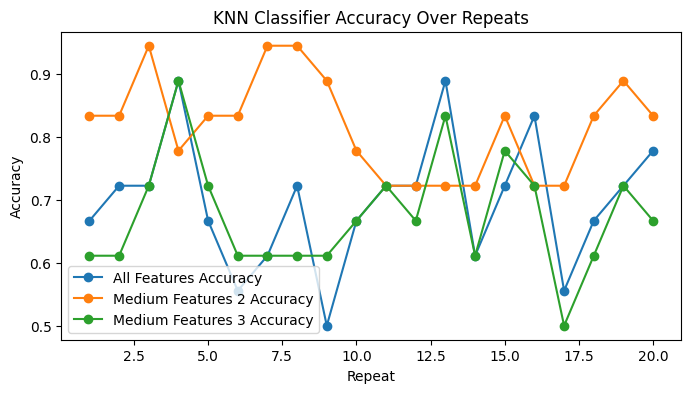

In [75]:

# اجرای تابع نهایی:
knn_evaluation_by_accuracy(X_data, y_data , medium_features_2  , medium_features_3, data_features, test_size=0.10, n_repeats=20)


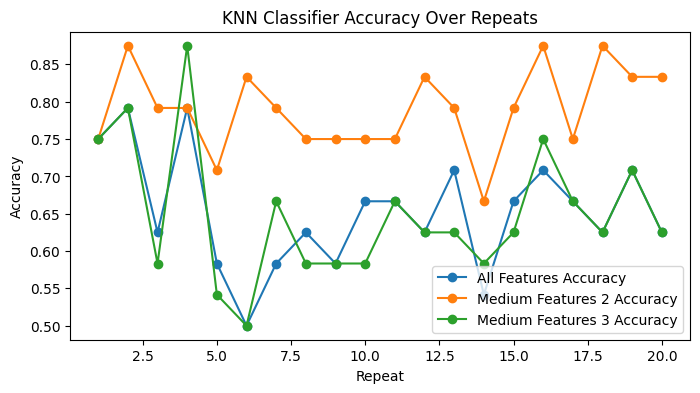

In [77]:

# اجرای تابع نهایی:
knn_evaluation_by_accuracy(X_data, y_data , medium_features_2  , medium_features_3, data_features, test_size=0.13, n_repeats=20)


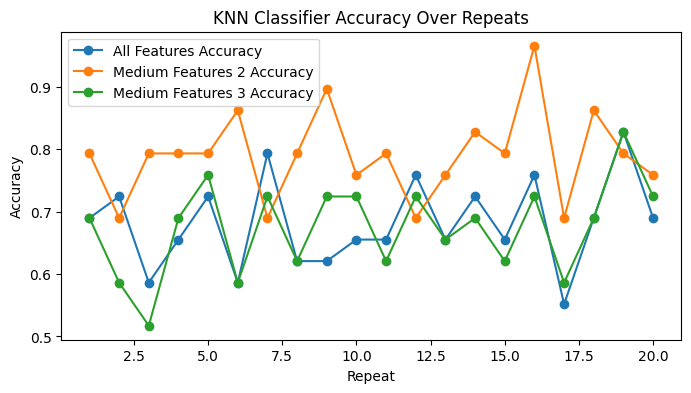

In [78]:

# اجرای تابع نهایی:
knn_evaluation_by_accuracy(X_data, y_data , medium_features_2  , medium_features_3, data_features, test_size=0.16, n_repeats=20)


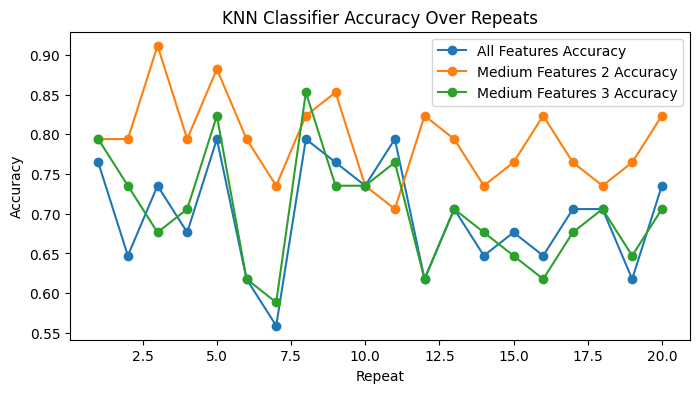

In [79]:

# اجرای تابع نهایی:
knn_evaluation_by_accuracy(X_data, y_data , medium_features_2  , medium_features_3, data_features, test_size=0.19, n_repeats=20)


🔎 Feature Group Performance Summary (by Accuracy):
                         Feature  Accuracy
6                     flavanoids  0.842697
9                color_intensity  0.780899
11  od280/od315_of_diluted_wines  0.769663
12                       proline  0.764045
0                        alcohol  0.764045
10                           hue  0.747191
5                  total_phenols  0.724719
1                     malic_acid  0.713483
8                proanthocyanins  0.674157
4                      magnesium  0.640449
3              alcalinity_of_ash  0.589888
7           nonflavanoid_phenols  0.584270
2                            ash  0.578652

📊 Grouped Feature Performance Summary (Accuracy Only):
       Feature_Group  Accuracy
0       All Features  0.786517
1    Strong Features       NaN
2  Medium (0.9-0.95)       NaN
3   Medium (0.8-0.9)  0.842697
4   Medium (0.7-0.8)  0.825843
5   Medium (0.6-0.7)  0.775281
6   Medium (0.5-0.6)  0.786517
7      Poor Features       NaN


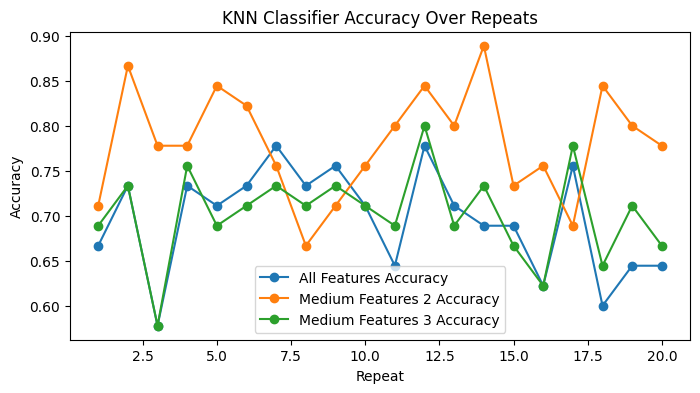

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# [1] تابع جدید برای اولویت‌بندی ویژگی‌ها بر اساس دقت KNN
def features_prioritization_by_accuracy(X, y, features):
    features_scores = []
    knn_cls = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_cls.fit(X_feature, y)
        y_pred = knn_cls.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        features_scores.append((feature, acc))

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
    return df_scores

# [2] تابع امن برای محاسبه دقت روی گروهی از ویژگی‌ها
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)

# [3] بارگذاری دیتاست
data = load_wine()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data= data.target
data_features = data.feature_names

# [4] اولویت‌بندی ویژگی‌ها بر اساس Accuracy
data_scores = features_prioritization_by_accuracy(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (by Accuracy):")
print(data_scores)

# [5] دسته‌بندی ویژگی‌ها بر اساس Accuracy
strong_features = data_scores[data_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['Accuracy'] > 0.9)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['Accuracy'] > 0.8)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['Accuracy'] > 0.7) ]['Feature'].tolist()
medium_features_4 = data_scores[(data_scores['Accuracy'] > 0.6) ]['Feature'].tolist()
medium_features_5 = data_scores[(data_scores['Accuracy'] > 0.5) ]['Feature'].tolist()
poor_features = data_scores[data_scores['Accuracy'] <= 0.5]['Feature'].tolist()


# [6] تابع برای محاسبه R² با Regressor (همانند نسخه اصلی)
def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    y_pred = model.predict(X_subset)
    return accuracy_score(y_data, y_pred)  # از accuracy استفاده شده است به‌جای R²

# [7] محاسبه دقت و accuracy برای هر گروه
groups = [data_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [8] ساخت جدول خلاصه
summary_df = pd.DataFrame({
    'Feature_Group': ['All Features', 'Strong Features', 'Medium (0.9-0.95)', 'Medium (0.8-0.9)',
                      'Medium (0.7-0.8)', 'Medium (0.6-0.7)', 'Medium (0.5-0.6)', 'Poor Features', ],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary (Accuracy Only):")
print(summary_df)

# [9] تابع نهایی برای ارزیابی با تکرار (مطابق نسخه شما ولی بر پایه دسته‌بندی جدید)
def knn_evaluation_by_accuracy(X_data, y_data  , medium_features_2  , medium_features_3 ,  data_features, test_size, n_repeats):
    r2_scores = {
        "all_features": [],

        "medium_features_2": [],
        "medium_features_3": []
    }
    accuracy_scores = {
        "all_features": [],

        "medium_features_2": [],
        "medium_features_3": []
    }

    feature_groups = {
        "all_features": data_features,


        "medium_features_2": medium_features_2,
        "medium_features_3": medium_features_3
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # Regressor (به عنوان مقایسه، ولی همچنان از Classifier استفاده شده است)
            k=int(np.sqrt(len(X_train)))
            knn_cls = KNeighborsClassifier(n_neighbors=k)
            knn_cls.fit(X_train[group_features], y_train)
            y_pred_cls = knn_cls.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred_cls)
            accuracy_scores[group_name].append(acc)

    # رسم نمودار دقت
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 4))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()} Accuracy", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.show()

# اجرای تابع نهایی:
knn_evaluation_by_accuracy(X_data, y_data , medium_features_2  , medium_features_3, data_features, test_size=0.25, n_repeats=20)
